In [39]:
# base: https://github.com/Followb1ind1y/Face-Mask-Detection/tree/main

import os
import json
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import albumentations as A
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import time
from tqdm import trange

main_dir = "...root..." 
train_dir = "train" 
val_dir = "val"
test_dir = "test"
image_dir = "images"
annotation_dir = "annotations" 
model_dir = "model"

# main_dir
# ---- train_dir
# -------- images
# -------- annotations
# ---- val_dir
# -------- images
# -------- annotations
# ---- test_dir
# -------- images
# -------- annotations

batch_size = 4
num_classes = 3
num_epochs = 30
model_name = "model_epoch_"

# buildings (class 1) and forrest outliers (class 2)
# return example ([[0 1 0 1], [1 1 3 2], [1 3 5 4]] [1, 1, 2])
def get_annotations_boxes_from_json(file):
    boxes = []
    annotations = []
    with open(file, 'r') as f:
        data = json.load(f)

        for _ in data["shapes"]:
            
            x1 = _["points"][0][0]
            y1 = _["points"][0][1]
            x2 = _["points"][1][0]
            y2 = _["points"][1][1]
            
            if x1 < x2:
                xmin = x1
                xmax = x2
            else:
                xmin = x2
                xmax = x1
                
            if y1 < y2:
                ymin = y1
                ymax = y2
            else:
                ymin = y2
                ymax = y1
            
            points = [xmin, ymin, xmax, ymax]
            
            if _["label"] == "building":
                label_id = 1
            else:
                label_id = 2
            boxes.append(points)    
            annotations.append(label_id)    
    return boxes, annotations

class UrbanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir(os.path.join(root, image_dir))))
        self.anns = list(sorted(os.listdir(os.path.join(root, annotation_dir))))
        self.img_dir = os.path.join(root, image_dir)
        self.ann_dir = os.path.join(root, annotation_dir)
    
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, idx):
        curr_img_dir = os.path.join(self.img_dir, self.imgs[idx])
        curr_ann_dir = os.path.join(self.ann_dir, self.anns[idx])

        image = Image.open(curr_img_dir, mode='r').convert('RGB')
        boxes, labels = get_annotations_boxes_from_json(curr_ann_dir)
        
        boxes = torch.FloatTensor(boxes)
        labels = torch.LongTensor(labels)

        if self.transforms:
            transformed = self.transforms(image=image, bboxes=boxes, category_ids=labels)

        tenn = transforms.ToTensor()
        image = tenn(image)

        return image, boxes, labels

    def collate_fn(self, batch):
        return tuple(zip(*batch))

data_transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(p=0.5),
        A.RandomBrightnessContrast(p=0.3),
        A.RGBShift(r_shift_limit=30, g_shift_limit=30, b_shift_limit=30, p=0.3),
    ],
    bbox_params=A.BboxParams(format='coco', label_fields=['category_ids']),
)

image_datasets = {x: UrbanDataset(root=os.path.join(main_dir, x), transforms=None) for x in [train_dir, val_dir, test_dir]}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                              shuffle=True, collate_fn=image_datasets[x].collate_fn) for x in [train_dir, val_dir, test_dir]}
dataset_sizes = {x: len(image_datasets[x]) for x in [train_dir, val_dir, test_dir]}
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def display_boundary(image, boxes, labels, score = None):

    label_to_name = {1: 'Building', 2: 'Outlier'}
    label_to_color = {1: 'red', 2: 'green'}

    transform = torchvision.transforms.ToPILImage()
    image = transform(image)
    boxes = boxes.tolist()
    labels = labels.tolist()

    img_bbox = ImageDraw.Draw(image)

    for idx in range(len(boxes)):
        img_bbox.rectangle(boxes[idx], outline=label_to_color[labels[idx]], width=2)
        if score == None: 
            img_bbox.text((boxes[idx][0], boxes[idx][1]-15), label_to_name[labels[idx]], 
                          align ="left", fill=label_to_color[labels[idx]]) 
        else:
            img_bbox.text((boxes[idx][0], boxes[idx][1]-15), label_to_name[labels[idx]]+' '+ f"{score[idx].item():.2%}", 
                          align ="left", fill=label_to_color[labels[idx]])
    
    return image

def display_images(**images):
    num_images = len(images)
    plt.figure(figsize=(15,15))
    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, num_images, idx + 1)
        plt.xticks([]); 
        plt.yticks([])
        plt.title(name.replace('_',' ').title(), fontsize=15)
        plt.imshow(image)
    plt.show()

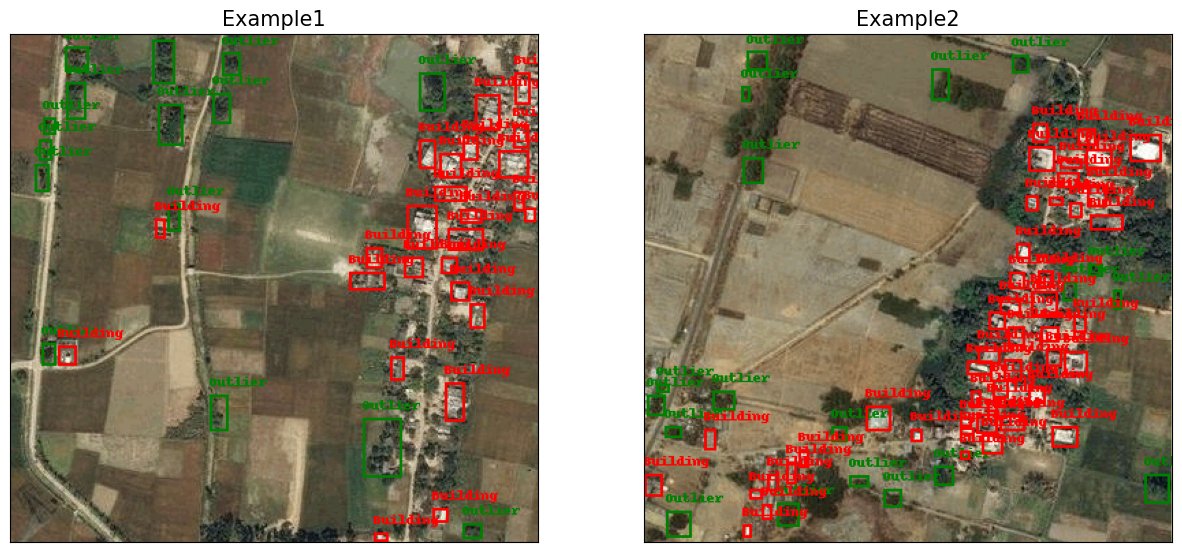

In [40]:
images, boxes, labels = next(iter(dataloaders[train_dir]))

display_images(
    Example1=display_boundary(images[0], boxes[0], labels[0]),
    Example2=display_boundary(images[1], boxes[1], labels[1])
)

In [41]:
weights = torchvision.models.detection.FasterRCNN_MobileNet_V3_Large_FPN_Weights.DEFAULT
model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn(weights=weights)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
# model.eval()

In [42]:
def save_model(model: torch.nn.Module, target_dir: str, epoch: int):
    target_dir_path = Path(target_dir)
    target_dir_path.mkdir(parents=True, exist_ok=True)
    check_point_name = model_name + str(epoch)
    model_save_path = target_dir_path / check_point_name
    torch.save(obj=model.state_dict(), f=model_save_path)

def plot_curve(results: dict, epochs: int):
    train_losses = np.array(results["train_loss"])
    plt.plot(np.arange(epochs, step=1), train_losses, label='Train loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()
    
def bbox_iou(box1, box2):
    b1_x1, b1_y1, b1_x2, b1_y2 = box1[0], box1[1], box1[2], box1[3]
    b2_x1, b2_y1, b2_x2, b2_y2 = box2[0], box2[1], box2[2], box2[3]

    inter_rect_x1 = torch.max(b1_x1, b2_x1)
    inter_rect_y1 = torch.max(b1_y1, b2_y1)
    inter_rect_x2 = torch.min(b1_x2, b2_x2)
    inter_rect_y2 = torch.min(b1_y2, b2_y2)

    inter_area = torch.clamp(inter_rect_x2 - inter_rect_x1 + 1, min=0) * torch.clamp(
        inter_rect_y2 - inter_rect_y1 + 1, min=0
    )

    b1_area = (b1_x2 - b1_x1 + 1) * (b1_y2 - b1_y1 + 1)
    b2_area = (b2_x2 - b2_x1 + 1) * (b2_y2 - b2_y1 + 1)

    iou = inter_area / (b1_area + b2_area - inter_area + 1e-16)

    return iou

Progress:   0%|          | 0/30 [00:00<?, ?it/s]


Epoch 1: Train loss: 1.5033030609289806


Progress:   3%|▎         | 1/30 [00:02<01:23,  2.87s/it]


Epoch 2: Train loss: 1.4056847443183262


Progress:   7%|▋         | 2/30 [00:05<01:16,  2.72s/it]


Epoch 3: Train loss: 1.3637804090976715


Progress:  10%|█         | 3/30 [00:07<01:08,  2.56s/it]


Epoch 4: Train loss: 1.24492051700751


Progress:  13%|█▎        | 4/30 [00:10<01:06,  2.56s/it]


Epoch 5: Train loss: 1.2289143552382786


Progress:  17%|█▋        | 5/30 [00:12<01:02,  2.52s/it]


Epoch 6: Train loss: 1.203758989771207


Progress:  20%|██        | 6/30 [00:15<00:59,  2.47s/it]


Epoch 7: Train loss: 1.168975720802943


Progress:  23%|██▎       | 7/30 [00:17<00:57,  2.49s/it]


Epoch 8: Train loss: 1.0992112358411152


Progress:  27%|██▋       | 8/30 [00:20<00:53,  2.45s/it]


Epoch 9: Train loss: 1.0963455587625504


Progress:  30%|███       | 9/30 [00:22<00:50,  2.42s/it]


Epoch 10: Train loss: 1.1381751795609791


Progress:  33%|███▎      | 10/30 [00:24<00:47,  2.39s/it]


Epoch 11: Train loss: 1.1000862469275792


Progress:  37%|███▋      | 11/30 [00:27<00:45,  2.41s/it]


Epoch 12: Train loss: 1.06362081070741


Progress:  40%|████      | 12/30 [00:29<00:42,  2.38s/it]


Epoch 13: Train loss: 1.099911908308665


Progress:  43%|████▎     | 13/30 [00:31<00:40,  2.38s/it]


Epoch 14: Train loss: 1.0929607699314754


Progress:  47%|████▋     | 14/30 [00:34<00:37,  2.35s/it]


Epoch 15: Train loss: 1.0959289769331615


Progress:  50%|█████     | 15/30 [00:36<00:34,  2.30s/it]


Epoch 16: Train loss: 1.0604841311772664


Progress:  53%|█████▎    | 16/30 [00:38<00:31,  2.24s/it]


Epoch 17: Train loss: 1.0670365939537685


Progress:  57%|█████▋    | 17/30 [00:40<00:28,  2.21s/it]


Epoch 18: Train loss: 1.078094984094302


Progress:  60%|██████    | 18/30 [00:42<00:26,  2.20s/it]


Epoch 19: Train loss: 1.0918575177590053


Progress:  63%|██████▎   | 19/30 [00:44<00:23,  2.17s/it]


Epoch 20: Train loss: 1.0881402244170506


Progress:  67%|██████▋   | 20/30 [00:47<00:21,  2.16s/it]


Epoch 21: Train loss: 1.07481483121713


Progress:  70%|███████   | 21/30 [00:49<00:19,  2.15s/it]


Epoch 22: Train loss: 1.0621059288581212


Progress:  73%|███████▎  | 22/30 [00:51<00:17,  2.15s/it]


Epoch 23: Train loss: 1.0813542306423187


Progress:  77%|███████▋  | 23/30 [00:53<00:15,  2.19s/it]


Epoch 24: Train loss: 1.0823587328195572


Progress:  80%|████████  | 24/30 [00:55<00:13,  2.17s/it]


Epoch 25: Train loss: 1.0652352819840114


Progress:  83%|████████▎ | 25/30 [00:58<00:11,  2.21s/it]


Epoch 26: Train loss: 1.0605052610238392


Progress:  87%|████████▋ | 26/30 [01:00<00:08,  2.19s/it]


Epoch 27: Train loss: 1.0703518937031429


Progress:  90%|█████████ | 27/30 [01:02<00:06,  2.23s/it]


Epoch 28: Train loss: 1.07047205666701


Progress:  93%|█████████▎| 28/30 [01:04<00:04,  2.22s/it]


Epoch 29: Train loss: 1.0944159428278606


Progress:  97%|█████████▋| 29/30 [01:06<00:02,  2.20s/it]


Epoch 30: Train loss: 1.0850129773219426


Progress: 100%|██████████| 30/30 [01:09<00:00,  2.31s/it]



--------------------
Training complete in 1m 9s


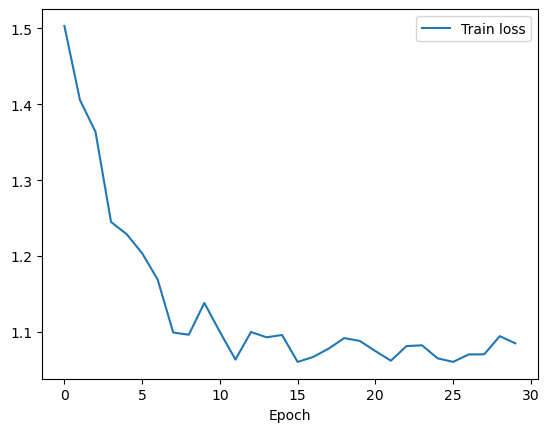

In [43]:
class Trainer:
    def __init__(self, 
                 model: torch.nn.Module,
                 dataloaders: torch.utils.data.DataLoader,
                 epochs: int, 
                 metric: torch.nn.Module, 
                 criterion: torch.nn.Module, 
                 optimizer: torch.optim.Optimizer,
                 scheduler: torch.optim.lr_scheduler,
                 save_dir: str,
                 device: torch.device):
        
        self.model = model
        self.train_dataloader = dataloaders[train_dir]
        self.val_dataloader = dataloaders[val_dir]
        self.epoch = 0
        self.epochs = epochs
        self.metric = None
        self.criterion = None
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.save_dir = save_dir
        self.device = device

        self.results = {"train_loss": [],
                        "train_iou": [],
                        "val_loss": [],
                        "val_iou": []
                        }
        
    def train_model(self):
        start_time = time.time()

        progressbar = trange(self.epochs, desc="Progress")
        for _ in progressbar:
            self.epoch += 1
            self.train_epoch()
            print(f'\nEpoch {self.epoch}: Train loss: {self.results["train_loss"][-1]}')
            save_model(self.model, self.save_dir, self.epoch)

        time_elapsed = time.time() - start_time
        print('\n')
        print('-' * 20)
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        plot_curve(results=self.results, epochs=self.epochs)

        return self.results

    def train_epoch(self):
        self.model.train()
        running_losses = []

        for images, boxes, labels in self.train_dataloader:
            images = list(img.to(self.device) for img in images)
            boxes = [b.to(self.device) for b in boxes]
            labels = [l.to(self.device) for l in labels]
            targets = []

            for i in range(len(images)):
                d = {}
                d['boxes'] = boxes[i]
                d['labels'] = labels[i]
                targets.append(d)

            self.optimizer.zero_grad()

            loss_dict = self.model(images, targets)
            loss = sum(loss for loss in loss_dict.values())
            loss_value = loss.item()
            running_losses.append(loss_value)

            loss.backward()
            self.optimizer.step()

        self.scheduler.step()
        self.results["train_loss"].append(np.mean(running_losses))

    def val_epoch(self):
        self.model.eval()
        running_ious, running_losses = [], []

        for x, y in self.val_dataloader:
            inputs = x.to(self.device)
            targets = y.to(self.device)

            with torch.no_grad():
                outputs = self.model(inputs)
                loss = self.criterion(outputs, targets)
                loss_value = loss.item()
                running_losses.append(loss_value)

                iou_value = self.metric(outputs, targets)
                running_ious.append(iou_value)

        self.results["val_loss"].append(np.mean(running_losses))
        self.results["val_iou"].append(np.mean(running_ious))
        
import torch.optim as optim
from torch.optim import lr_scheduler

model = model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer_RCNN = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
exp_lr_scheduler_RCNN = lr_scheduler.StepLR(optimizer_RCNN, step_size=7, gamma=0.1)

trainer = Trainer(model=model,
                  dataloaders=dataloaders,
                  epochs=num_epochs,
                  metric=None,
                  criterion=None, 
                  optimizer=optimizer_RCNN,
                  scheduler=exp_lr_scheduler_RCNN,
                  save_dir=main_dir + "/" + model_dir,
                  device=device)

model_results = trainer.train_model()

In [45]:
count_epoch = []

for filename in os.listdir(main_dir + "/" + model_dir):
    count_epoch.append(int(filename.split("_")[2]))

dir_load = main_dir + "/" + model_dir + "/" + model_name + str(max(count_epoch))    

model_state = torch.load(dir_load)
model.load_state_dict(model_state)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer_UNet = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
exp_lr_scheduler_UNet = lr_scheduler.StepLR(optimizer_UNet, step_size=7, gamma=0.1)

def remove_low_risk_box(predictions, threshold):

    for img in range(len(predictions)):
        for idx in range(predictions[img]['labels'].shape[0]):
            if predictions[img]['scores'][idx] < threshold:
                predictions[img]['boxes'] = predictions[img]['boxes'][0:idx]
                predictions[img]['labels'] = predictions[img]['labels'][0:idx]
                predictions[img]['scores'] = predictions[img]['scores'][0:idx]
                break

    return predictions
    
def nms_pytorch(P : torch.tensor, labels: torch.tensor, scores: torch.tensor, thresh_iou : float):
    x1 = P[:, 0]
    y1 = P[:, 1]
    x2 = P[:, 2]
    y2 = P[:, 3]
 
    areas = (x2 - x1) * (y2 - y1)
    order = scores.argsort()
    pred_dict = {'boxes':[], 'labels':[], 'scores':[]}
     
    while len(order) > 0:
        idx = order[-1]
        if len(pred_dict['boxes']) == 0:
            pred_dict['boxes'].append(torch.unsqueeze(P[idx], dim=0))
            pred_dict['labels'].append(torch.unsqueeze(labels[idx], dim=0))
            pred_dict['scores'].append(torch.unsqueeze(scores[idx], dim=0))
        else:
            pred_dict['boxes'][0] = torch.cat((pred_dict['boxes'][0], torch.unsqueeze(P[idx], dim=0)), dim=0)
            pred_dict['labels'][0] = torch.cat((pred_dict['labels'][0], torch.unsqueeze(labels[idx], dim=0)), dim=0)
            pred_dict['scores'][0] = torch.cat((pred_dict['scores'][0], torch.unsqueeze(scores[idx], dim=0)), dim=0)
 
        order = order[:-1]
 
        if len(order) == 0:
            break
         
        xx1 = torch.index_select(x1,dim = 0, index = order)
        xx2 = torch.index_select(x2,dim = 0, index = order)
        yy1 = torch.index_select(y1,dim = 0, index = order)
        yy2 = torch.index_select(y2,dim = 0, index = order)

        xx1 = torch.max(xx1, x1[idx])
        yy1 = torch.max(yy1, y1[idx])
        xx2 = torch.min(xx2, x2[idx])
        yy2 = torch.min(yy2, y2[idx])
 
        w = xx2 - xx1
        h = yy2 - yy1
         
        w = torch.clamp(w, min=0.0)
        h = torch.clamp(h, min=0.0)
 
        inter = w*h
 
        rem_areas = torch.index_select(areas, dim = 0, index = order) 
 
        union = (rem_areas - inter) + areas[idx]
         
        IoU = inter / union
 
        mask = IoU < thresh_iou
        order = order[mask]
    
    pred_dict['boxes'], pred_dict['labels'], pred_dict['scores'] = pred_dict['boxes'][0], pred_dict['labels'][0], pred_dict['scores'][0]
    return pred_dict

def apply_nms(predictions, threshold):
    nms_list = []
    for img in range(len(predictions)):
        nms_list.append(nms_pytorch(predictions[img]['boxes'], predictions[img]['labels'], predictions[img]['scores'], threshold))
    return nms_list

images, boxes, labels = next(iter(dataloaders[test_dir]))
images = list(img.to(device) for img in images)

model.eval()
predictions = model(images)
predictions = remove_low_risk_box(predictions=predictions, threshold=0.5)
predictions = apply_nms(predictions, 0.5)

C:\Users\user\AppData\Local\Temp\ipykernel_4784\1880773406.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_state = torch.load(dir_load)


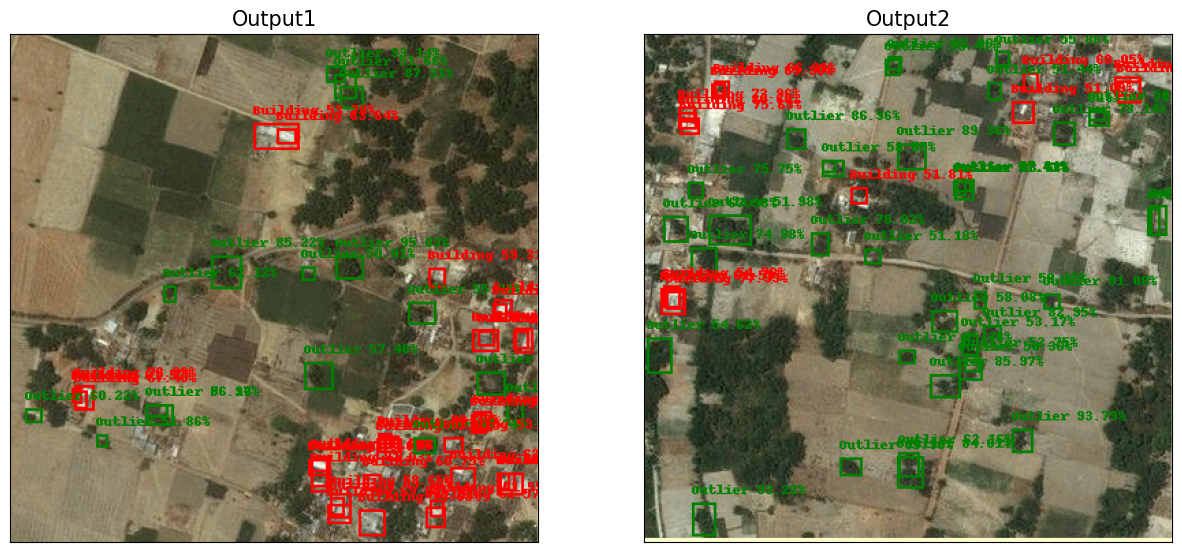

In [46]:
display_images(
    Output1=display_boundary(images[0], predictions[0]['boxes'], predictions[0]['labels'], predictions[0]['scores']),
    Output2=display_boundary(images[1], predictions[1]['boxes'], predictions[1]['labels'], predictions[1]['scores'])
)